In [14]:
import numpy as np
import matplotlib.pyplot as plt
import folium as fo
from folium import plugins
import fcgadgets.macgyver.util_gis as gis
import rasterio
from rasterio import warp
from matplotlib import cm
from pyproj import Transformer 

In [ ]:
## LC08 RGB Image or particular Band Image
#in_path=r'C:\Data\BC1ha\LandCoverUse\LandCover_Comp1_2019.tif'
pthin=r'C:\Data\BC1ha\LandCoverUse\LandCover_Comp1_2019.tif'
pthout=r'C:\Data\BC1ha\LandCoverUse\LandCover_Comp1_2019_Merc1.tif'
gis.ReprojectGeoTiff(pthin,pthout,'EPSG:4326')
dst_crs='EPSG:4326'
with rasterio.open(pthout) as src:
    img = src.read()[0::20,0::20]
    src_crs = src.crs['init'].upper()
    min_lon, min_lat, max_lon, max_lat = src.bounds
    
## Conversion from UTM to WGS84 CRS
bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
bounds_fin = []
for item in bounds_orig:   
    #converting to lat/lon
    lat = item[0]
    lon = item[1]    
    proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
    lon_n, lat_n = proj.transform(lon, lat)    
    bounds_fin.append([lat_n, lon_n])
img=img.astype('float')
img=img/np.max(img)*10 # normalization
#img[img==0]=np.nan
# Finding the centre latitude & longitude    
centre_lon = bounds_fin[0][1] + (bounds_fin[1][1] - bounds_fin[0][1])/2
centre_lat = bounds_fin[0][0] + (bounds_fin[1][0] - bounds_fin[0][0])/2
m=fo.Map(location=[centre_lat, centre_lon],zoom_start=10) # ,tiles='Stamen Terrain'
# Overlay raster using add_child() function
m.add_child(fo.raster_layers.ImageOverlay(img.transpose(1, 2, 0),opacity=.6,bounds=bounds_fin,colormap=plt.colormaps['Blues']))
fo.LayerControl().add_to(m)
m

In [2]:
#z=gis.OpenGeoTiff(r'C:\Data\BC1ha\LandCoverUse\LandUse_Comp1_2019.tif')

In [3]:
pthin=r'C:\Data\BC1ha\LandCoverUse\LandCover_Comp1_2019.tif'
pthout=r'C:\Data\BC1ha\LandCoverUse\LandCover_Comp1_2019_Merc.tif'
#gis.ReprojectGeoTiff(pthin,pthout,'EPSG:3875')
z=gis.OpenGeoTiff(pthout)

In [5]:
z.keys()

dict_keys(['gt', 'Data', 'X', 'Y', 'm', 'n', 'yxrat', 'xmin', 'xmax', 'ymin', 'ymax', 'xlim', 'ylim', 'Extent', 'Cellsize', 'Transform', 'Projection', 'Proj4_String', 'crs'])

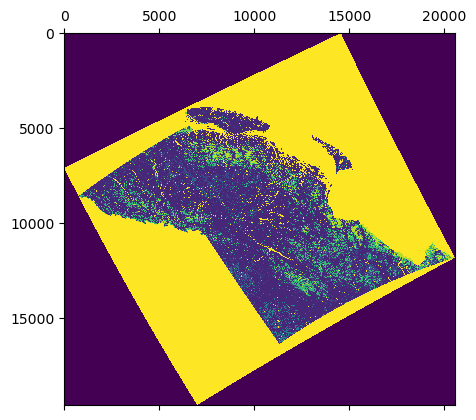

In [12]:
dat=rasterio.open(pthout,'r') # open raster file
d1=dat.read()[0]
plt.matshow(d1)

In [6]:
ivl=10
z0=z['Data'][0::ivl,0::ivl].astype('float')
z0=z0/np.max(z0)*10 # normalization
ind=np.where(z0==0); z0[ind]=np.nan
#plt.matshow(z0); plt.show()

In [7]:
# set bounds using wgs84 projection (geotiff is in web mercator)
dest_crs='EPSG:4326'
#left,bottom,right,top=[i for i in dataset.bounds]
left,bottom,right,top=z['xmin'],z['ymin'],z['xmax'],z['ymax']
bounds_4326=warp.transform_bounds(src_crs=z['crs'],dst_crs=dest_crs,left=left,bottom=bottom,right=right,top=top)

In [9]:
left,right

(18213521.725322627, 20398969.777848408)


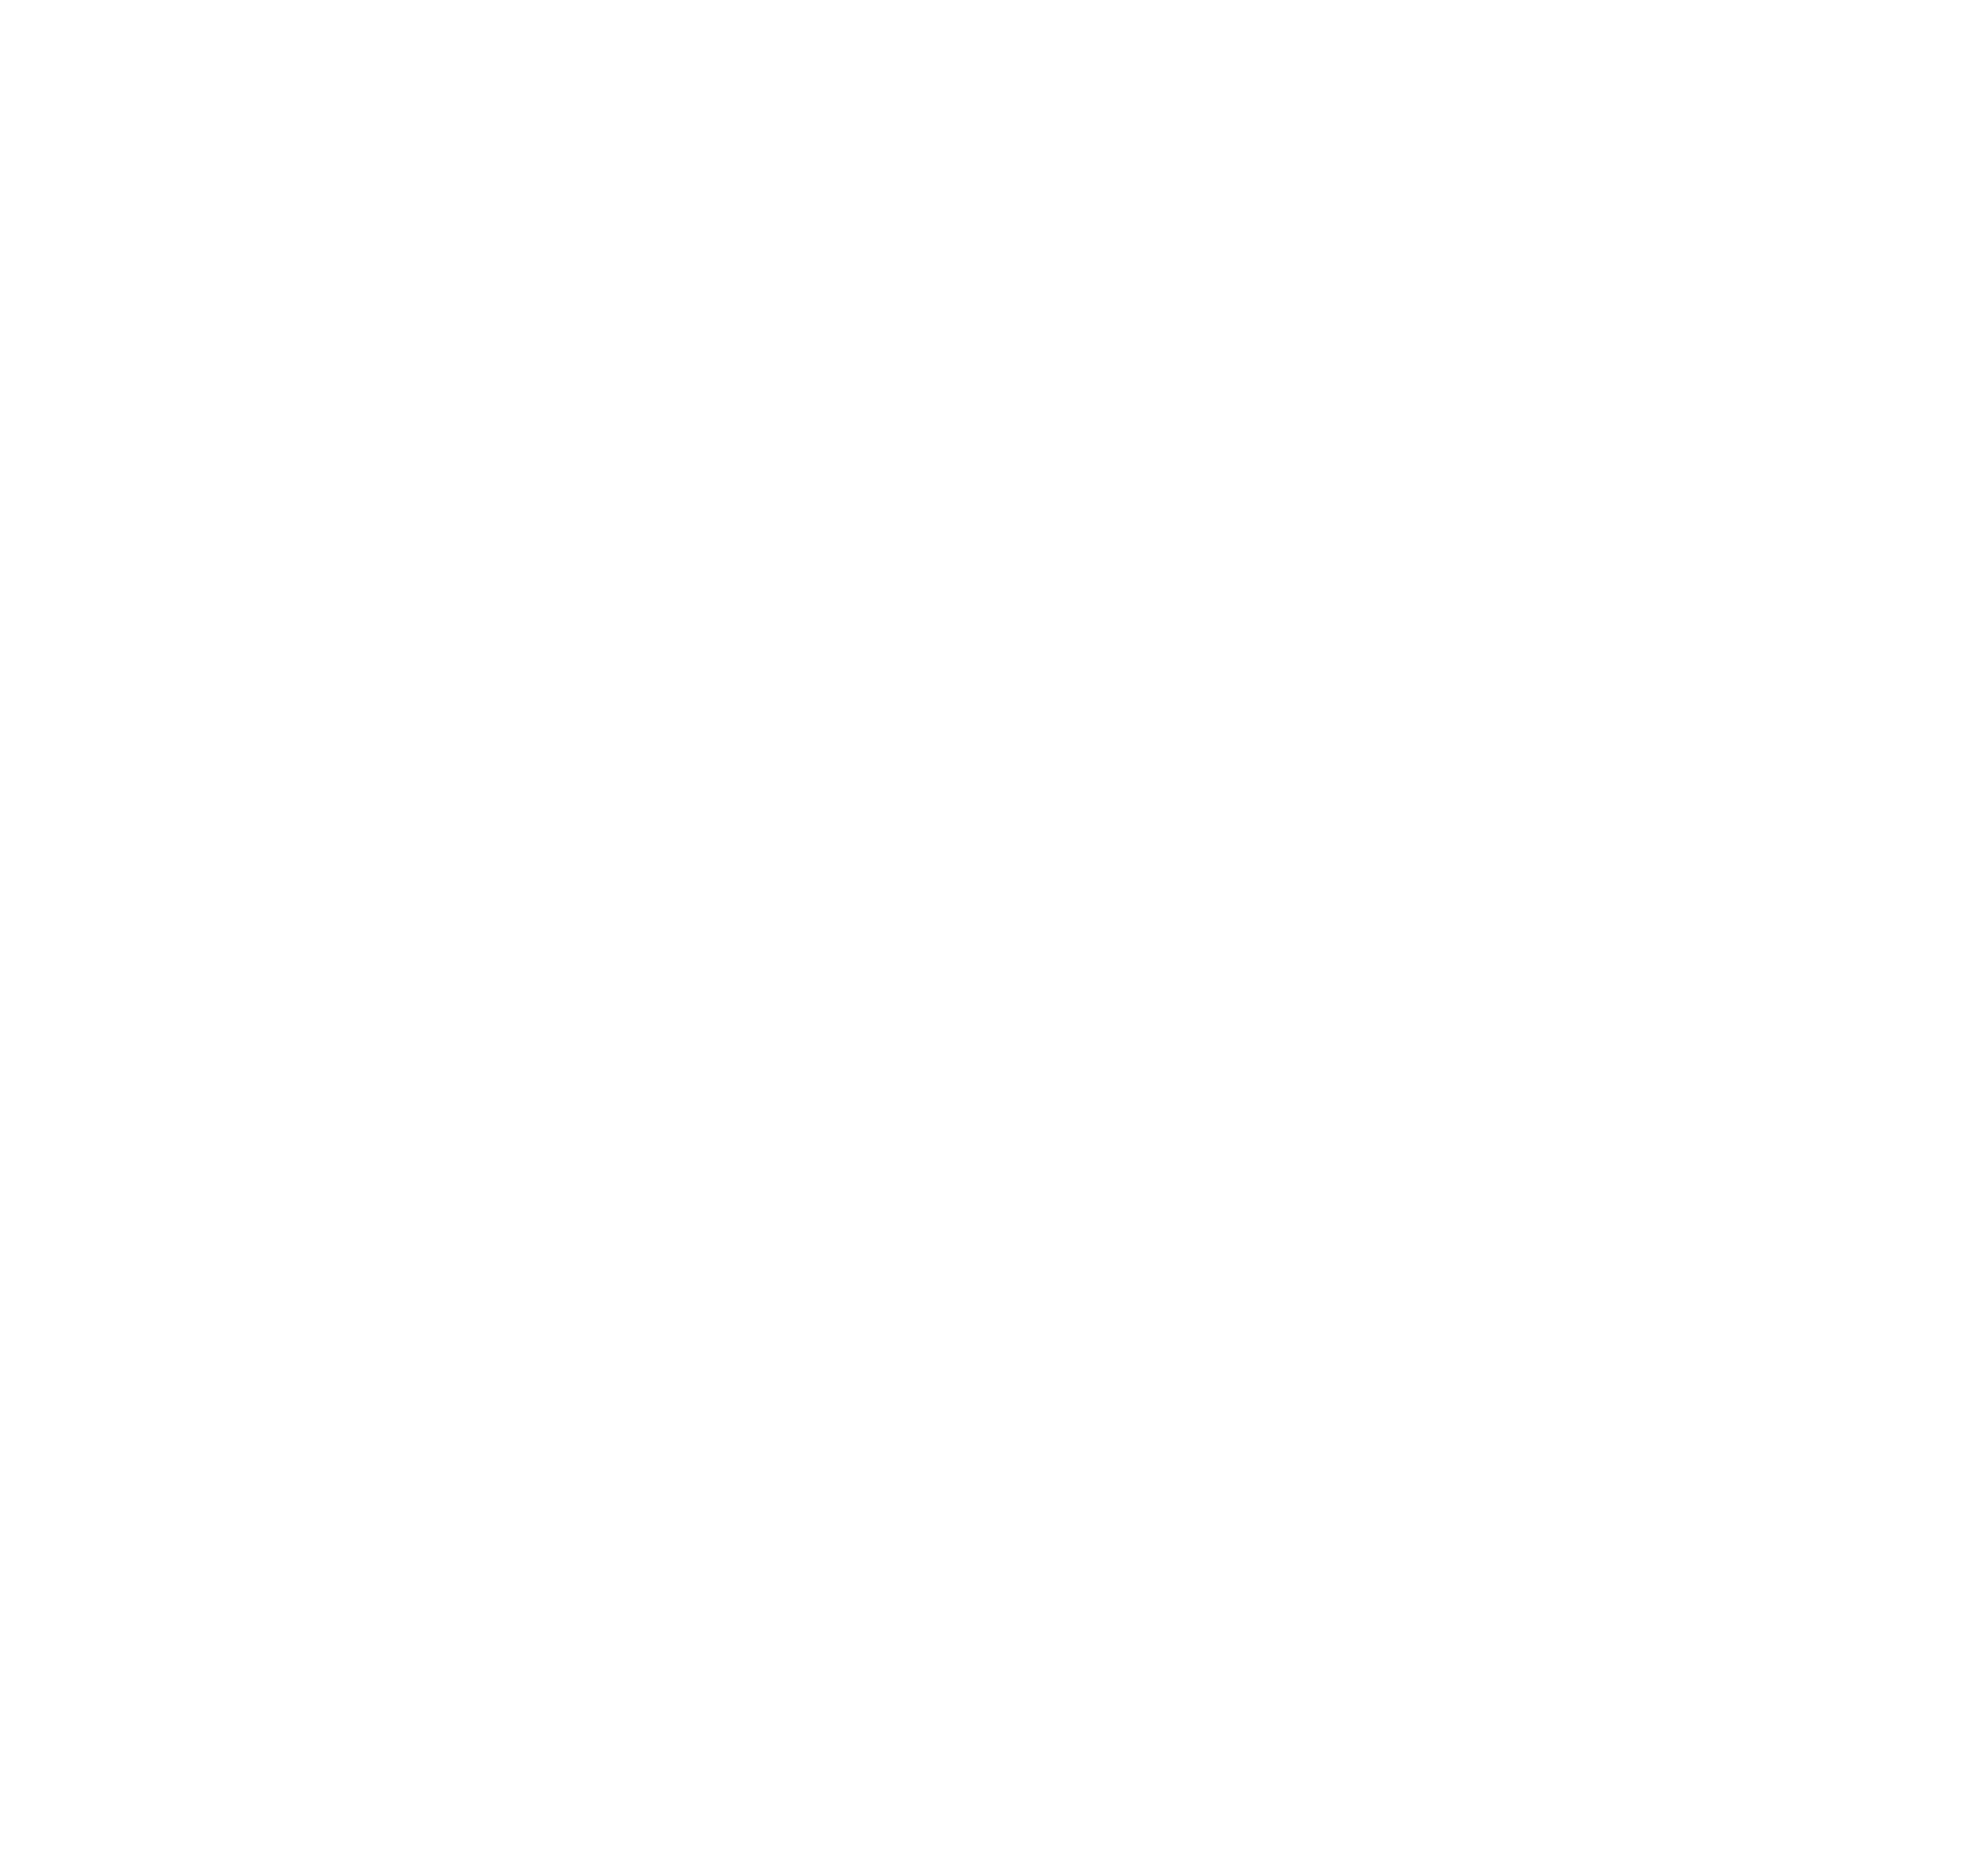

In [8]:
m=fo.Map([55,-122],zoom_start=8)
fo.raster_layers.ImageOverlay(
    image=z0,
    name='sample map',
    opacity=0.5,
    bounds=bounds_4326,
    interactive=False,
    cross_origin=False,
    colormap=plt.colormaps['Blues'],
    zindex=1).add_to(m)
fo.LayerControl().add_to(m)
m

In [77]:
img=fo.raster_layers.ImageOverlay(
        name="Mercator projection SW",
        image=z['Data'][0::10,0::10],
        bounds=bnds,
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1)
img.add_to(m)
#fo.LayerControl().add_to(m)

In [42]:
# Add custom base maps to fo
basemaps = {
    'Google Maps': fo.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': fo.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': fo.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': fo.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': fo.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}
basemaps['Google Maps'].add_to(m)
basemaps['Google Satellite Hybrid'].add_to(m)

In [43]:
# Import plugins 
m.add_child(fo.LayerControl()) # Add a layer control panel to the map.
plugins.Fullscreen().add_to(m) # #fullscreen
#plugins.LocateControl().add_to(m)
#mouse position
#fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};" 
#plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:",lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)
#Add the draw 
#plugins.Draw(export=True, filename='data.geojson', position='topleft', draw_options=None, edit_options=None).add_to(m)  
#Add measure tool 
#plugins.MeasureControl(position='topright', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(m)